<a href="https://colab.research.google.com/github/OtavioBer/ProjAplicadoIII/blob/To-Fix/modelo_recomendacao_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

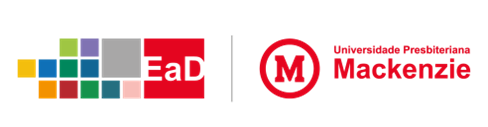

#<font color=blue>Projeto Aplicado III - Modelo de Recomendação de Livros

CURSO: Tecnologia em Ciências de Dados

SEMESTRE: 4º

COMPONENTE CURRICULAR / TEMA: Projeto Aplicado III

NOME DO PROFESSOR: THIAGO DONIZETTI DOS SANTOS

INTEGRANTES E TIA:

1. Caroline Ribeiro Ferreira - 10408052
2. Lais César Fonseca - 10407066
3. Leonardo dos Reis Olher – 10407752
4. Liliane Gonçalves de Brito Ferraz - 10407087
5. Múcio Emanuel Feitosa Ferraz Filho - 10218691
6. Otavio Bernardo Scandiuzzi - 10407867

##<font color=blue>OBJETIVO

Implementar um sistema de recomendação de livros usando análise de dados e aprendizado de máquina, explorando diferentes abordagens para recomendação com base em características dos livros e preferências dos usuários.
Passando por etapas de tratamento dos dados, técnica do modelo, prova de conceito e a forma de avaliação do desempenho.

## 1. Importanto Bibliotecas e Dados

In [ ]:
# Importando bibliotecas e pacotes a serem utilizados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Image, display, HTML
import warnings; warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import torch.nn.functional as F

### Cuda
- Verificar disponibilidade de GPU.

In [ ]:
#Verificar o nível de processamento do GPU
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 3050


### Label Encoder
- Codificar dados para aplicar treinamento do modelo.

In [ ]:
# CODIFICAR DADOS
def encoder_df(df):
    enc = {}
    df_enc = {}

    for col in df.columns.tolist():
        enc[col] = LabelEncoder().fit(df[col])
        df_enc[col] = enc[col].transform(df[col])

    df_enc = pd.DataFrame(df_enc)
    return enc, df_enc

# CODIFICAR PREDIÇÃO
def predict_encoder(df, enc):

    predict_enc = {}

    for col in df.columns.tolist():

        try:
            predict_enc[col] = enc[col].transform(df[col])

        except:
            continue

    return pd.DataFrame(predict_enc)

# DECODIFICAR PREDIÇÃO
def predict_uncoder(df, enc):

    predict_unc = {}

    for col in df.columns.tolist():

        try:
            predict_unc[col] = enc[col].inverse_transform(df[col].astype(int))

        except:
            predict_unc[col] = df[col]

    return pd.DataFrame(predict_unc)

## 2. Carregar Dados, Tratamento e Limpeza dos Dados
- Trazer bases em formato dataframe;
- Unir bases em um único dataframe.

In [ ]:
# CARREGAR DADOS
users = pd.read_csv('../Dados/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')
ratings = pd.read_csv('../Dados/BX-Book-Ratings.csv', delimiter=';', encoding = 'ISO-8859-1')
books = pd.read_csv('../Dados/BX_Books.csv', delimiter=';', encoding = 'ISO-8859-1')

Realizar a limpeza, pré-processamento e transformação dos dados brutos em um formato adequado para análise, incluindo remoção de duplicidades e/ou valores ausentes e adequação de variáveis categóricas.

In [ ]:
# SEPARAR PAIS DO LOCATION
users['Country'] = users['Location'].apply(lambda x: x.split(', ')[-1])
# users = users.sample(10000)

# UNIR BASES
df = ratings\
    .merge(users, how='inner', on='User-ID')\
    .merge(books, how='inner', on='ISBN')

# LIMPEZA DE DADOS
df = df\
    .dropna()\
    .drop_duplicates()\
    .drop(['Location','Image-URL-M','Image-URL-L'], axis=1)

# FILTRAR COLUNAS UTILIZADAS NO MODELO
cols = ['User-ID','ISBN','Book-Author','Publisher','Country','Year-Of-Publication','Age','Book-Rating']
avaliacoes = df[cols]
avaliacoes.reset_index(drop=True, inplace=True)

# CLASSIFICAÇÕES
avaliacoes['HIGH_RATING'] = (avaliacoes['Book-Rating'] >= 8).astype(int)

# RETIRAR RATING
avaliacoes.drop('Book-Rating', axis=1, inplace=True)

# RETIRAR USUARIOS QUE AVALIARAM MENOS QUE 2 LIVROS COM 8,9,10
count_avaliacoes_high = avaliacoes.groupby('User-ID', as_index=False).agg({'HIGH_RATING':sum})
count_avaliacoes_high = count_avaliacoes_high[count_avaliacoes_high['HIGH_RATING'] > 2]
count_avaliacoes_high = count_avaliacoes_high['User-ID'].tolist()
avaliacoes = avaliacoes[avaliacoes['User-ID'].isin(count_avaliacoes_high)]

# CODIFICAR DADOS
enc, df_enc = encoder_df(avaliacoes)

### Balanceamento dos dados
- Undersampling

In [ ]:
print('BASE DESBALANCEADA:\n')
print(avaliacoes['HIGH_RATING'].value_counts(), end='\n\n\n\n')

# REMOVER PARTE DO RATING MAJORITARIO
x, y = RandomUnderSampler(sampling_strategy='majority').fit_resample(df_enc.drop('HIGH_RATING', axis=1), y=df_enc['HIGH_RATING'])
x['HIGH_RATING'] = y

print('BASE BALANCEADA:\n')
print(x['HIGH_RATING'].value_counts())

# SPLIT TREINO TESTE
train, test = train_test_split(x, test_size=.2, shuffle=True)

BASE DESBALANCEADA:

HIGH_RATING
0    486218
1    140091
Name: count, dtype: int64



BASE BALANCEADA:

HIGH_RATING
0    140091
1    140091
Name: count, dtype: int64


## 3. Implementação do Modelo
- Criação do modelo de recomendação com pytorch

O modelo de recomendação é implementado usando redes neurais profundas (DNN). Ele usa embeddings para representar usuários e livros, que são aprendidos durante o treinamento.

In [ ]:
# MODELO DE RECOMENDAÇÃO
class ModeloRecomendacao(nn.Module):

    def __init__(self, n, emb=10):

        super().__init__()

        self.emb1 = nn.Embedding(n[0]+1, emb)
        self.emb2 = nn.Embedding(n[1]+1, emb)
        self.emb3 = nn.Embedding(n[2]+1, emb)
        self.emb4 = nn.Embedding(n[3]+1, emb)
        self.emb5 = nn.Embedding(n[4]+1, emb)

        self.layers = nn.Sequential(
                          nn.Linear(emb*5+2, 1024),
                          nn.ReLU(),
                          nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Linear(256, 128),
                          nn.ReLU(),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Linear(64, 32),
                          nn.ReLU(),
                          nn.Linear(32, 16),
                          nn.ReLU(),
                          nn.Linear(16, 8),
                          nn.ReLU(),
                          nn.Linear(8, 4),
                          nn.ReLU(),
                          nn.Linear(4, 2),
                          nn.ReLU(),
                          nn.Linear(2, 1),
                          nn.Sigmoid())


    def forward(self, x):
        x1 = self.emb1(x[:,0].long())
        x2 = self.emb2(x[:,1].long())
        x3 = self.emb3(x[:,2].long())
        x4 = self.emb4(x[:,3].long())
        x5 = self.emb5(x[:,4].long())

        x = torch.cat([x1, x2, x3, x4, x5, x[:,5:]], dim=1)

        output = self.layers(x)

        return output

### Dataset
- Transformar dados em tensores.

In [ ]:
class AvaliacoesDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        X = self.data.iloc[i, :-1].values
        Y = self.data.iloc[i, -1:]

        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        return X, Y

### Preparação Modelo
- Definição do Device que será aplicado (GPU ou CPU);
- Definição de hiperparametros;
- Definição de otimizador do modelo;
- Definição do erro;
- Transformação de Torchs dos dados;
- Transformação em Dataloader dos dados.

A implantação deste código visa treinar o modelo para prever a preferência de um usuário por um livro com base em características.
O desempenho do modelo é avaliado usando a métrica de erro quadrático médio (MSE) calculada sobre um conjunto de dados de teste separado. Quanto menor o MSE, melhor é o desempenho do modelo em prever as avaliações dos usuários.

In [ ]:
# DEVICE
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# HIPERPAMETROS
lr=1e-3
load_checkpoint = True

# Modelo de Recomendação
n = []
for col in cols[:5]:
    n.append(df_enc[col].max())

model = ModeloRecomendacao(n, emb=100).to(device)

# Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Load Model
if load_checkpoint:
    loaded = torch.load('model.pth.tar')
    model.load_state_dict(loaded['state_dict'])
    optimizer.load_state_dict(loaded['optimizer'])

# Mean Squared Error
lossfunc = nn.MSELoss()

# DataSet
train_dataset = AvaliacoesDataset(train)
test_dataset = AvaliacoesDataset(test)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1_000, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

## 4. Treinamento do Modelo
- Treinar modelo por X epocas;
- Calcular erro;
- Aplicar backpropagation no modelo;
- Gravar evolução dos erros.

O modelo é treinado utilizando um conjunto de dados que consiste em avaliações de usuários sobre livros. Durante o treinamento, o modelo aprende a prever a avaliação que um usuário daria a um livro específico com base em várias características do livro e do usuário.

In [ ]:
# TREINO MODELO
epochs = 206
train_results = {'epochs':[], 'loss':[]}

for epoch in range(epochs):
    train_loss = 0.0
    corrects = 0
    values = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = model.forward(x).to(device)
        loss = lossfunc(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_results['epochs'].append(epoch)
    train_results['loss'].append(train_loss/len(train_dataloader))

    if epoch % 5 == 0:
        corrects += torch.sum((output>.5).float() == y)
        values += len(output)
        checkpoint = {'state_dict':model.state_dict(), 'optimizer':optimizer.state_dict()}
        torch.save(checkpoint, 'model.pth.tar')
        print(f'Epochs: {epoch:>10} | Train Loss: {train_loss/len(train_dataloader):>6.4f} | Accuracy: {corrects/values:>6.4f}')

Epochs:          0 | Train Loss: 0.0134 | Accuracy: 0.9862
Epochs:          5 | Train Loss: 0.0130 | Accuracy: 0.9862
Epochs:         10 | Train Loss: 0.0119 | Accuracy: 0.9862
Epochs:         15 | Train Loss: 0.0121 | Accuracy: 0.9862
Epochs:         20 | Train Loss: 0.0120 | Accuracy: 0.9931
Epochs:         25 | Train Loss: 0.0114 | Accuracy: 0.9862
Epochs:         30 | Train Loss: 0.0116 | Accuracy: 0.9724
Epochs:         35 | Train Loss: 0.0114 | Accuracy: 1.0000
Epochs:         40 | Train Loss: 0.0112 | Accuracy: 0.9931
Epochs:         45 | Train Loss: 0.0112 | Accuracy: 0.9931
Epochs:         50 | Train Loss: 0.0105 | Accuracy: 0.9862
Epochs:         55 | Train Loss: 0.0103 | Accuracy: 0.9931
Epochs:         60 | Train Loss: 0.0103 | Accuracy: 0.9793
Epochs:         65 | Train Loss: 0.0100 | Accuracy: 0.9793
Epochs:         70 | Train Loss: 0.0100 | Accuracy: 0.9931
Epochs:         75 | Train Loss: 0.0100 | Accuracy: 0.9862
Epochs:         80 | Train Loss: 0.0098 | Accuracy: 0.97

KeyboardInterrupt: 

## 5. Avaliação de Desempenho do Modelo

Plotamos um gráfico de linha para visualizar a evolução da perda ao longo das épocas de treinamento. Isso ajuda a entender como a perda diminui à medida que o modelo é treinado.

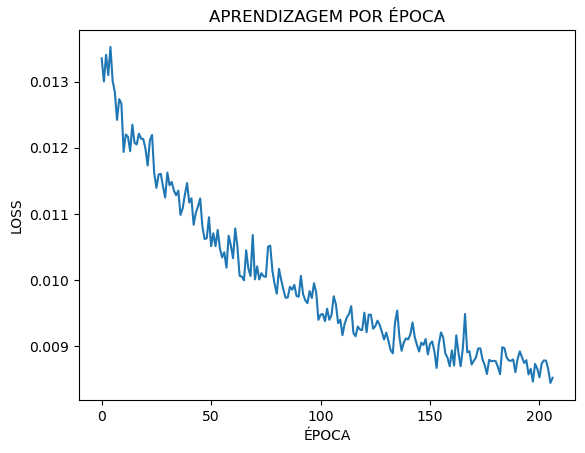

In [ ]:
#Evolução da Aprendizagem - Lineplot
train_results = pd.DataFrame(train_results)
sns.lineplot(train_results, x='epochs', y='loss')
plt.title('APRENDIZAGEM POR ÉPOCA')
plt.xlabel('ÉPOCA')
plt.ylabel('LOSS')
plt.show()

### Avaliar Modelo
- Gravar erro dos dados teste;
- Gravar previsão feita dos dados treino.

In [ ]:
# AVALIAÇÃO DO MODELO
model.eval()
test_loss = 0.0
final = {'User-ID':[], 'ISBN':[], 'Book-Author':[], 'Year-Of-Publication':[], 'Publisher':[], 'Country':[], 'Age':[], 'PRED_HIGH_RATING':[], 'TRUE_HIGH_RATING':[]}
with torch.no_grad():
    corrects = 0
    values = 0
    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)
        output = model.forward(x).to(device)
        test_loss += lossfunc(output, y).item()
        # X
        final['User-ID'].append(x[:,0].tolist()[0])
        final['ISBN'].append(x[:,1].tolist()[0])
        final['Book-Author'].append(x[:,2].tolist()[0])
        final['Year-Of-Publication'].append(x[:,3].tolist()[0])
        final['Publisher'].append(x[:,4].tolist()[0])
        final['Country'].append(x[:,5].tolist()[0])
        final['Age'].append(x[:,6].tolist()[0])

        # Y_PREDICT
        final['PRED_HIGH_RATING'].append(output[:,0].tolist()[0])

        # Y_TRUE
        final['TRUE_HIGH_RATING'].append(y[:,0].tolist()[0])

        # ACCURACY
        corrects += torch.sum((output>.5).float() == y)
        values += len(output)

final = pd.DataFrame(final)
print(f'Test Loss: {test_loss/len(test_dataloader):.4f} | Accuracy: {corrects/values:>6.4f} |')

Test Loss: 0.2416 | Accuracy: 0.7431 |


1. **Test Loss (Perda de Teste)**: Um valor de perda de teste de 0.02416 indica a média das diferenças entre as classificações previstas pelo modelo e as classificações reais nos dados de teste. Quanto menor o valor de perda, melhor o desempenho do modelo.

2. **Acurácia**: Uma acurácia de 0.7431 significa que o modelo classificou corretamente aproximadamente 74,31% das recomendações nos dados de teste. Das recomendações feitas pelo modelo, cerca de 74,31% delas estão corretas.

### Matriz de Confusão
- 1: Alta chance de gostar do livro (Maior igual 8).
- 0: Baixa chance de gostar do livro (Menor que 8).

[[20913  7185]
 [ 7209 20730]]



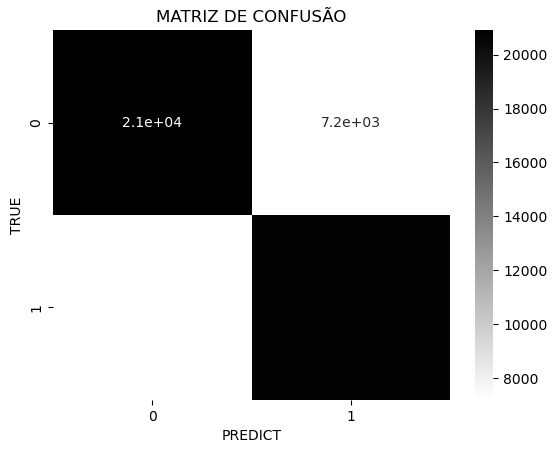

In [ ]:
# MATRIZ DE CONFUSÃO
final['PRED_HIGH_RATING'] = (final['PRED_HIGH_RATING'] > .5).astype(int)
conf_matriz = confusion_matrix(y_true=final['TRUE_HIGH_RATING'], y_pred=final['PRED_HIGH_RATING'])
print(conf_matriz, end='\n\n')
sns.heatmap(conf_matriz, cmap='binary', annot=True)
plt.title('MATRIZ DE CONFUSÃO')
plt.xlabel('PREDICT')
plt.ylabel('TRUE')
plt.show()

A partir dos resultados finais, é calculada a matriz de confusão para avaliar o desempenho do modelo. A matriz de confusão é impressa e plotada como um mapa de calor, onde as células mostram o número de previsões corretas e incorretas para cada classe. Isso ajuda a visualizar onde o modelo está acertando e errando.

## 6. Recomendação

A implementação deste código visa a recomendação de livros para um usuário específico, apresenta o resultado de indicação de livros que esteja de acordo com a sua preferência.

- Separar dados do User-ID informado;
- Unir dados do User-ID com toda a base de livros;
- Prever quais livros tem maior probabilidade de ter nota 9 ou 10 (High).

In [ ]:
# USUARIO QUE TERÁ RECOMENDAÇÃO
user_id = 8680
n_recomendacoes = 5

assert user_id in avaliacoes['User-ID'].unique().tolist()

# FILTRAR USUARIO NA BASE
user_filter = users[users['User-ID'] == user_id].iloc[0].tolist()

# RECOMENDAR LIVRO
predict_data = books[['Book-Title','ISBN','Image-URL-S','Book-Author','Year-Of-Publication','Publisher']].drop_duplicates()

# APENAS LIVROS TREINADOS PELO MODELO
predict_data = predict_data[predict_data['ISBN'].isin(avaliacoes['ISBN'].unique().tolist())]

# INCLUIR DADOS DO USER EM TODAS AS LINHAS
predict_data['User-ID'] = user_id
predict_data['Country'] = user_filter[3]
predict_data['Age'] = user_filter[2]

# REMOVER LIVROS JÁ AVALIDADOS PELO USUARIO
books_list = avaliacoes[avaliacoes['User-ID'] == user_id]['ISBN']
predict_data = predict_data[~predict_data['ISBN'].isin(books_list)].copy()
predict_encoded = predict_encoder(predict_data, enc)

# COLUNAS
cols_pred = cols.copy()
cols_pred.remove('Book-Rating')
predict_encoded = predict_encoded[cols_pred]
predict_encoded['y dummy high'] = 0

# DATASET
predict_dataset = AvaliacoesDataset(predict_encoded)

# DATALOADER
predict_dataloader = DataLoader(predict_dataset)

# RECOMENDAÇÃO DO MODELO
model.eval()
predict = {'User-ID':[], 'ISBN':[], 'Book-Author':[], 'Year-Of-Publication':[], 'Publisher':[], 'Country':[], 'Age':[], 'PRED_HIGH_RATING':[]}
with torch.no_grad():
    for x, y in predict_dataloader:
        x = x.to(device)
        output = model.forward(x).to(device)

        # X_VALUES
        predict['User-ID'].append(x[:,0].tolist()[0])
        predict['ISBN'].append(x[:,1].tolist()[0])
        predict['Book-Author'].append(x[:,2].tolist()[0])
        predict['Year-Of-Publication'].append(x[:,3].tolist()[0])
        predict['Publisher'].append(x[:,4].tolist()[0])
        predict['Country'].append(x[:,5].tolist()[0])
        predict['Age'].append(x[:,6].tolist()[0])

        # # Y_PREDICT
        predict['PRED_HIGH_RATING'].append(output[:,0].tolist()[0])

# TRANSFORMAR PREVISÃO EM DATAFRAME + ORDENAR DADOS DA MAIOR PROBABILIDADE DE SER UM LIVRO HIGH
predict = pd.DataFrame(predict)
recomendacao = predict.sort_values(by='PRED_HIGH_RATING', ascending=False)[:n_recomendacoes].copy().reset_index(drop=True)

# UNCODER DOS DADOS
recomendacao = predict_uncoder(recomendacao, enc)

# INCLUIR CAPA E TITILO DO LIVRO NA PREVISÃO
recomendacao = recomendacao.merge(books[['ISBN','Book-Title','Image-URL-S']], how='left', on='ISBN')

### Livros Recomendados ao User-ID
- Top livros com maior probabilidade de receber nota 8, 9 ou 10 (High);

In [ ]:
#Exibir a lista de recomendação com as imagens dos livros.
n = 1
for  _, row in recomendacao.iterrows():

    title = f'{n} - Titulo: {row["Book-Title"]}'
    isbn = f'ISBN: {row["ISBN"]}'
    url = row['Image-URL-S']
    display(HTML(f'<div><h3>{title}</h3><h4>{isbn}</h4><a href="{url}" target="_blank"><img src="{url}"></a></div>'))
    n+=1